# GPU 설정

In [3]:
# GPU 설정
import os
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7680)]  # 7.5GB
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# 메모리 정리 콜백
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

Metal device set to: 1 Physical GPUs, 1 Logical GPUs
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 13:04:28.912738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 13:04:28.913794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Inception

### 환경구성

In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### load & preprocess

In [6]:
def load_and_preprocess_data(base_dir, img_size=(299, 299)): # 이미지 크기 지정
    images = [] # image data를 모으는 빈 리스트 생성
    labels = [] # label data를 모으는 빈 리스트 생성
    categories = ['COVID19', 'NORMAL'] # class name

    for category in categories: # 각 카테고리에 대해 반복
        class_num = categories.index(category) # class name을 숫자로 변환
        base_path = os.path.join(base_dir, category) # 파일 경로 지정
        base_files = os.listdir(base_path) # 파일 리스트 생성
        np.random.shuffle(base_files) # 파일 순서 섞기
        for idx in range(400): # 임의로 train에서 500개의 데이터를 선정
          image_path = os.path.join(base_path, base_files[idx]) # 파일 경로 지정
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # 이미지를 GRAYSCALE로 불러옴
          image = cv2.resize(image, img_size) # 이미지 크기 지정
          image = image / 255.0 # 이미지 정규화
          images.append(image) # 이미지 리스트에 추가
          labels.append(class_num) # labels 리스트에 class_num추가

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1) # 4차원 데이터 입력 받음
    return images, np.array(labels) # 리스트 데이터를 array 타입으로 변환

def split_data(X, y, test_size=0.2, val_size=0.5): # train, validation, test 데이터 분리
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42) # stratify : 클래스의 비율을 맞춰서 분할
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42) # stratify : 클래스의 비율을 맞춰서 분할
    return X_train, y_train, X_val, y_val, X_test, y_test # 분리된 데이터 반환

In [7]:
base_dir = 'COVID-19/train' # 드라이브의 파일 경로 작성
X, y = load_and_preprocess_data(base_dir) # 데이터 불러오기

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # 데이터 분리하기

print("데이터 로딩 및 전처리 완료") # '데이터 로딩 및 전처리 완료' 문구 출력
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}") # 훈련데이터와 레이블 형태 출력
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}") # 검증데이터와 레이블 형태 출력
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}") # 테스트 데이터와 레이블 형태 출력

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (640, 299, 299, 1), 레이블 형태: (640,)
검증 데이터 형태: (80, 299, 299, 1), 레이블 형태: (80,)
테스트 데이터 형태: (80, 299, 299, 1), 레이블 형태: (80,)


### create model

In [8]:
def create_inceptionv3_model(input_shape): # InceptionV3 모델 생성
    base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=input_shape) # InceptionV3 모델 불러오기
    # include_top : 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 가중치 고정

    # 완전 연결 계층(inference)
    x = base_model.output # 베이스 모델에서 특징 추출
    x = GlobalAveragePooling2D()(x) # Global Average Pooling
    x = Dense(1024, activation='relu')(x) # 완전 연결 계층
    output = Dense(1, activation='sigmoid')(x) # 완전 연결 계층을 통과한 값을 마지막 출력층에서 입력으로 받고 출력층의 sigmoid 활성화 함수 거쳐 0과1사이의 예측값으로 반환

    model = Model(inputs=base_model.input, outputs=output) # 모델 생성
    return model # 모델 반환

### Inception 모델용 전처리

In [9]:
X_train_rgb = np.repeat(X_train, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장
X_val_rgb = np.repeat(X_val, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장
X_test_rgb = np.repeat(X_test, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장

# Inception 모델용 전처리 
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)  # Inception 모델의 전처리 함수 적용
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)  # 검증 데이터에 전처리 함수 적용
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)  # 테스트 데이터에 전처리 함수 적용

model = create_inceptionv3_model((299, 299, 3)) # 모델 생성
model.compile(optimizer=Adam(learning_rate=0.0001), # 구성에 대한 부분 집어넣기
              loss='binary_crossentropy', # sigmoid와 세트
              metrics=['accuracy']) # 정확도 출력

callbacks = [ # 오버피팅 방지, 가장 좋은 성능의 모델값만 나타나게 하기 위함
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), # 검증 손실이 10번의 에포크 동안 개선되지 않으면 학습 조기 종료, 최상의 가중치 복원
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)  # 가장 좋은 성능의 모델을 'best_inception_model.h5' 파일에 저장
]

2024-07-10 14:45:12.700536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 14:45:12.702245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [26]:
history = model.fit( # 모델학습 시작 , history 객체 학습 결과 저장
    X_train_preprocessed, y_train, # 학습에 사용할 훈련 데이터와 레이블
    validation_data=(X_val_preprocessed, y_val), # 검증 데이터
    epochs=50, # 100번 돌림
    batch_size=32, # 32씩 묶음
    callbacks=callbacks # 오버피팅 방지, 가장 좋은 성능의 모델값만 나타나게 하기 위함
)

Epoch 1/50


2024-07-10 13:13:49.370618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.5781

2024-07-10 13:14:02.916641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 19s 620ms/step - loss: 0.6484 - accuracy: 0.5781 - val_loss: 0.6032 - val_accuracy: 0.7375
Epoch 2/50
20/20 [==============================] - 10s 493ms/step - loss: 0.5595 - accuracy: 0.8578 - val_loss: 0.5264 - val_accuracy: 0.8875
Epoch 3/50
20/20 [==============================] - 10s 497ms/step - loss: 0.4972 - accuracy: 0.9016 - val_loss: 0.4690 - val_accuracy: 0.8875
Epoch 4/50
20/20 [==============================] - 10s 487ms/step - loss: 0.4409 - accuracy: 0.9250 - val_loss: 0.4216 - val_accuracy: 0.9000
Epoch 5/50
20/20 [==============================] - 10s 490ms/step - loss: 0.3943 - accuracy: 0.9250 - val_loss: 0.3863 - val_accuracy: 0.9000
Epoch 6/50
20/20 [==============================] - 10s 485ms/step - loss: 0.3636 - accuracy: 0.9219 - val_loss: 0.3468 - val_accuracy: 0.8875
Epoch 7/50
20/20 [==============================] - 10s 496ms/step - loss: 0.3272 - accuracy: 0.9281 - val_loss: 0.3205 - val_accuracy: 0.8875
Epoch 8/50

In [27]:
model = tf.keras.models.load_model('best_inception_model.h5') # 가중치 값을 저장, 학습 후 가장 높은 성능을 나타낸 가중치를 불러오기

In [28]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test) # 모델 평가
print(f'Test accuracy: {test_acc:.4f}') # Test Acuuracy 출력

2024-07-10 13:32:28.202351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 602ms/step - loss: 0.0468 - accuracy: 0.9875
Test accuracy: 0.9875


2024-07-10 13:37:31.290487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 4s 721ms/step


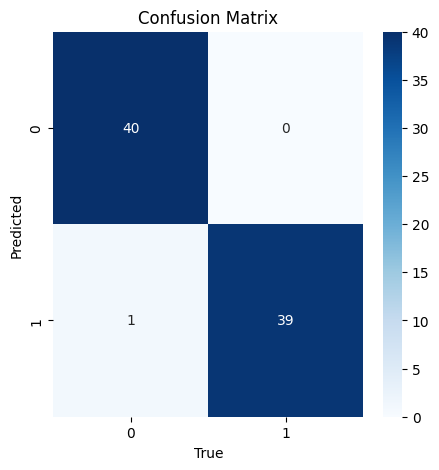

In [31]:
y_pred = model.predict(X_test_preprocessed)# 테스트 데이터셋에 대해 모델을 사용하여 예측 수행
y_pred_classes = (y_pred>0.5).astype(int) # 예측된 확률을 이진 클래스 레이블로 변환

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5)) # 그래프 그리는 칭구
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues' )# 빈도수 높을수록 색 찐해짐 heatmap
plt.title("Confusion Matrix") # 그래프 제목: Confusion Matrix
plt.xlabel('True') # x축: True
plt.ylabel('Predicted') # y축: Predicted
plt.show() # 그래프 보여주삼

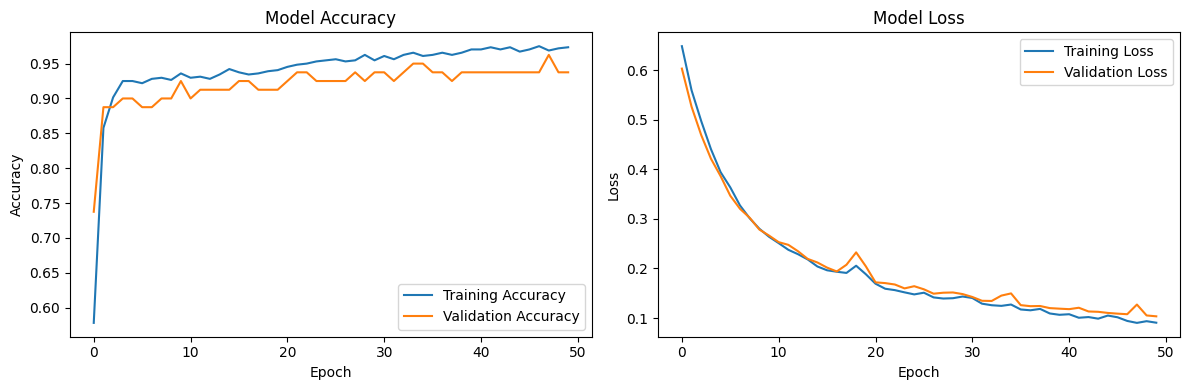

In [32]:
plt.figure(figsize=(12, 4)) # 새로운 figure 생성
plt.subplot(1, 2, 1) #1X2 suvplot 생성, 1번째 subplot 활성화
plt.plot(history.history['accuracy'], label='Training Accuracy') # 훈련 정확도 변화를 나타내는 그래프 생성
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # 검증 정확도 변화를 나타내는 그래프 생성
plt.title('Model Accuracy') # 그래프 제목: Model Accuracy
plt.xlabel('Epoch') # x축 label: Epoch
plt.ylabel('Accuracy') # y축 label: Accuracy
plt.legend() # 범례 추가

plt.subplot(1, 2, 2) # 두번째 subplot 활성화
plt.plot(history.history['loss'], label='Training Loss') # 그래프 그리기, label 설정
plt.plot(history.history['val_loss'], label='Validation Loss') #그래프 그리기, label 설정
plt.title('Model Loss') # 그래프 제목: Model Loss
plt.xlabel('Epoch') # x축 label: Epoch
plt.ylabel('Loss') # y축 label: Loss
plt.legend() # 범례 추가

plt.tight_layout() # 간격 조정
plt.show() # 그래프를 화면에 출력

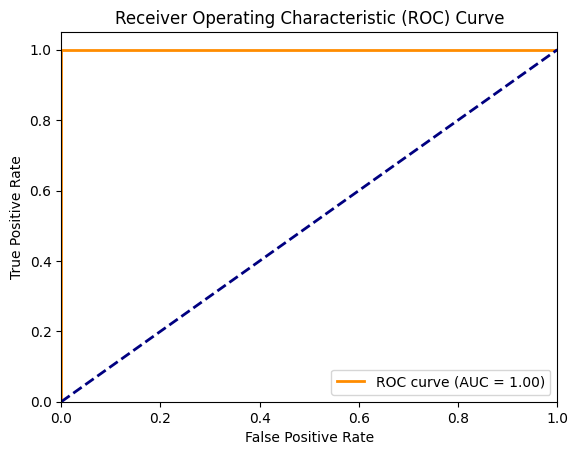

In [34]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred) # ROC 곡선의 fpr, tpr 값 계산
roc_auc = auc(fpr, tpr) # fpr, tpr 값 사용하여 auc 계산

# ROC 곡선 그리기
plt.figure()#새로운 그래프 생성
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')# Fpr, tpr 값으로 ROC curve 그림, 곡선의 색 ‘darkorange’, 곡선 두께 2, 곡선 레이블(roc_acu)은 소수점 두자리까지 표시.
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')# 네이비색 점선으로 기준선 생성 (0,1)에서(1,0)까지 대각선 형태
plt.xlim([0.0, 1.0]) #x축의 한계
plt.ylim([0.0, 1.05]) #y축의 한계
plt.xlabel('False Positive Rate')#x축 이름
plt.ylabel('True Positive Rate') #y축 이름
plt.title('Receiver Operating Characteristic (ROC) Curve') #그래프의 제목 지정
plt.legend(loc="lower right") #범례 지정
plt.show() # 그래프를 화면에 출력